### Demand Forcasting for a Retail Store 

#### Dataset: kaggle challenge- Store Item Demand Forcasting Challenge

##### 1. add data features

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [73]:
# Import training and test data
train = pd.read_csv("C:/Users/samee/OneDrive/Desktop/MScoursework/data science projects/Retail demand forcasting/Datasets/train.csv", parse_dates=['date'])
test = pd.read_csv("C:/Users/samee/OneDrive/Desktop/MScoursework/data science projects/Retail demand forcasting/Datasets/test.csv", parse_dates=['date'])

In [154]:
df = pd.concat([train, test], sort=False)
print(train.shape, test.shape, df.shape, "\n")
train.head()

(913000, 4) (45000, 4) (958000, 5) 



,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### Exploratory Data Analysis

In [77]:
# How many stores and items are there?
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 50, 50)

In [78]:
# Time Range
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [79]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [80]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [81]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

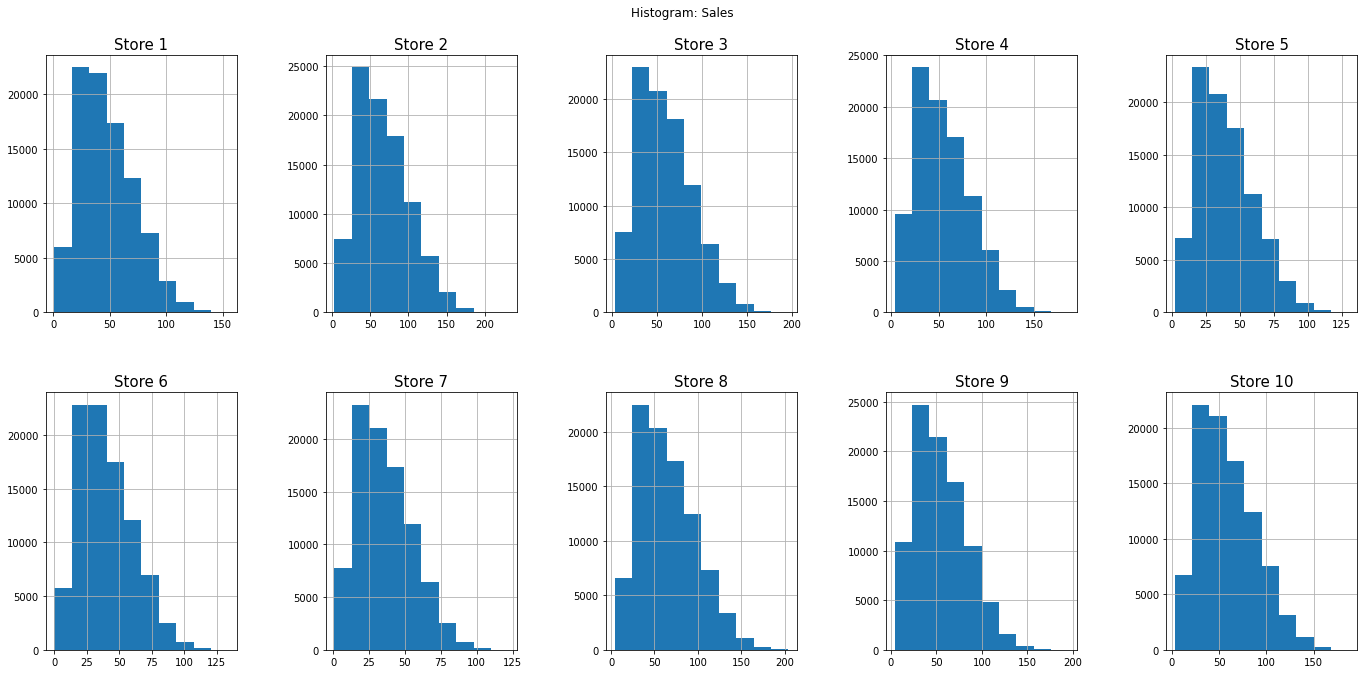

In [82]:
#histogram for store sales 

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

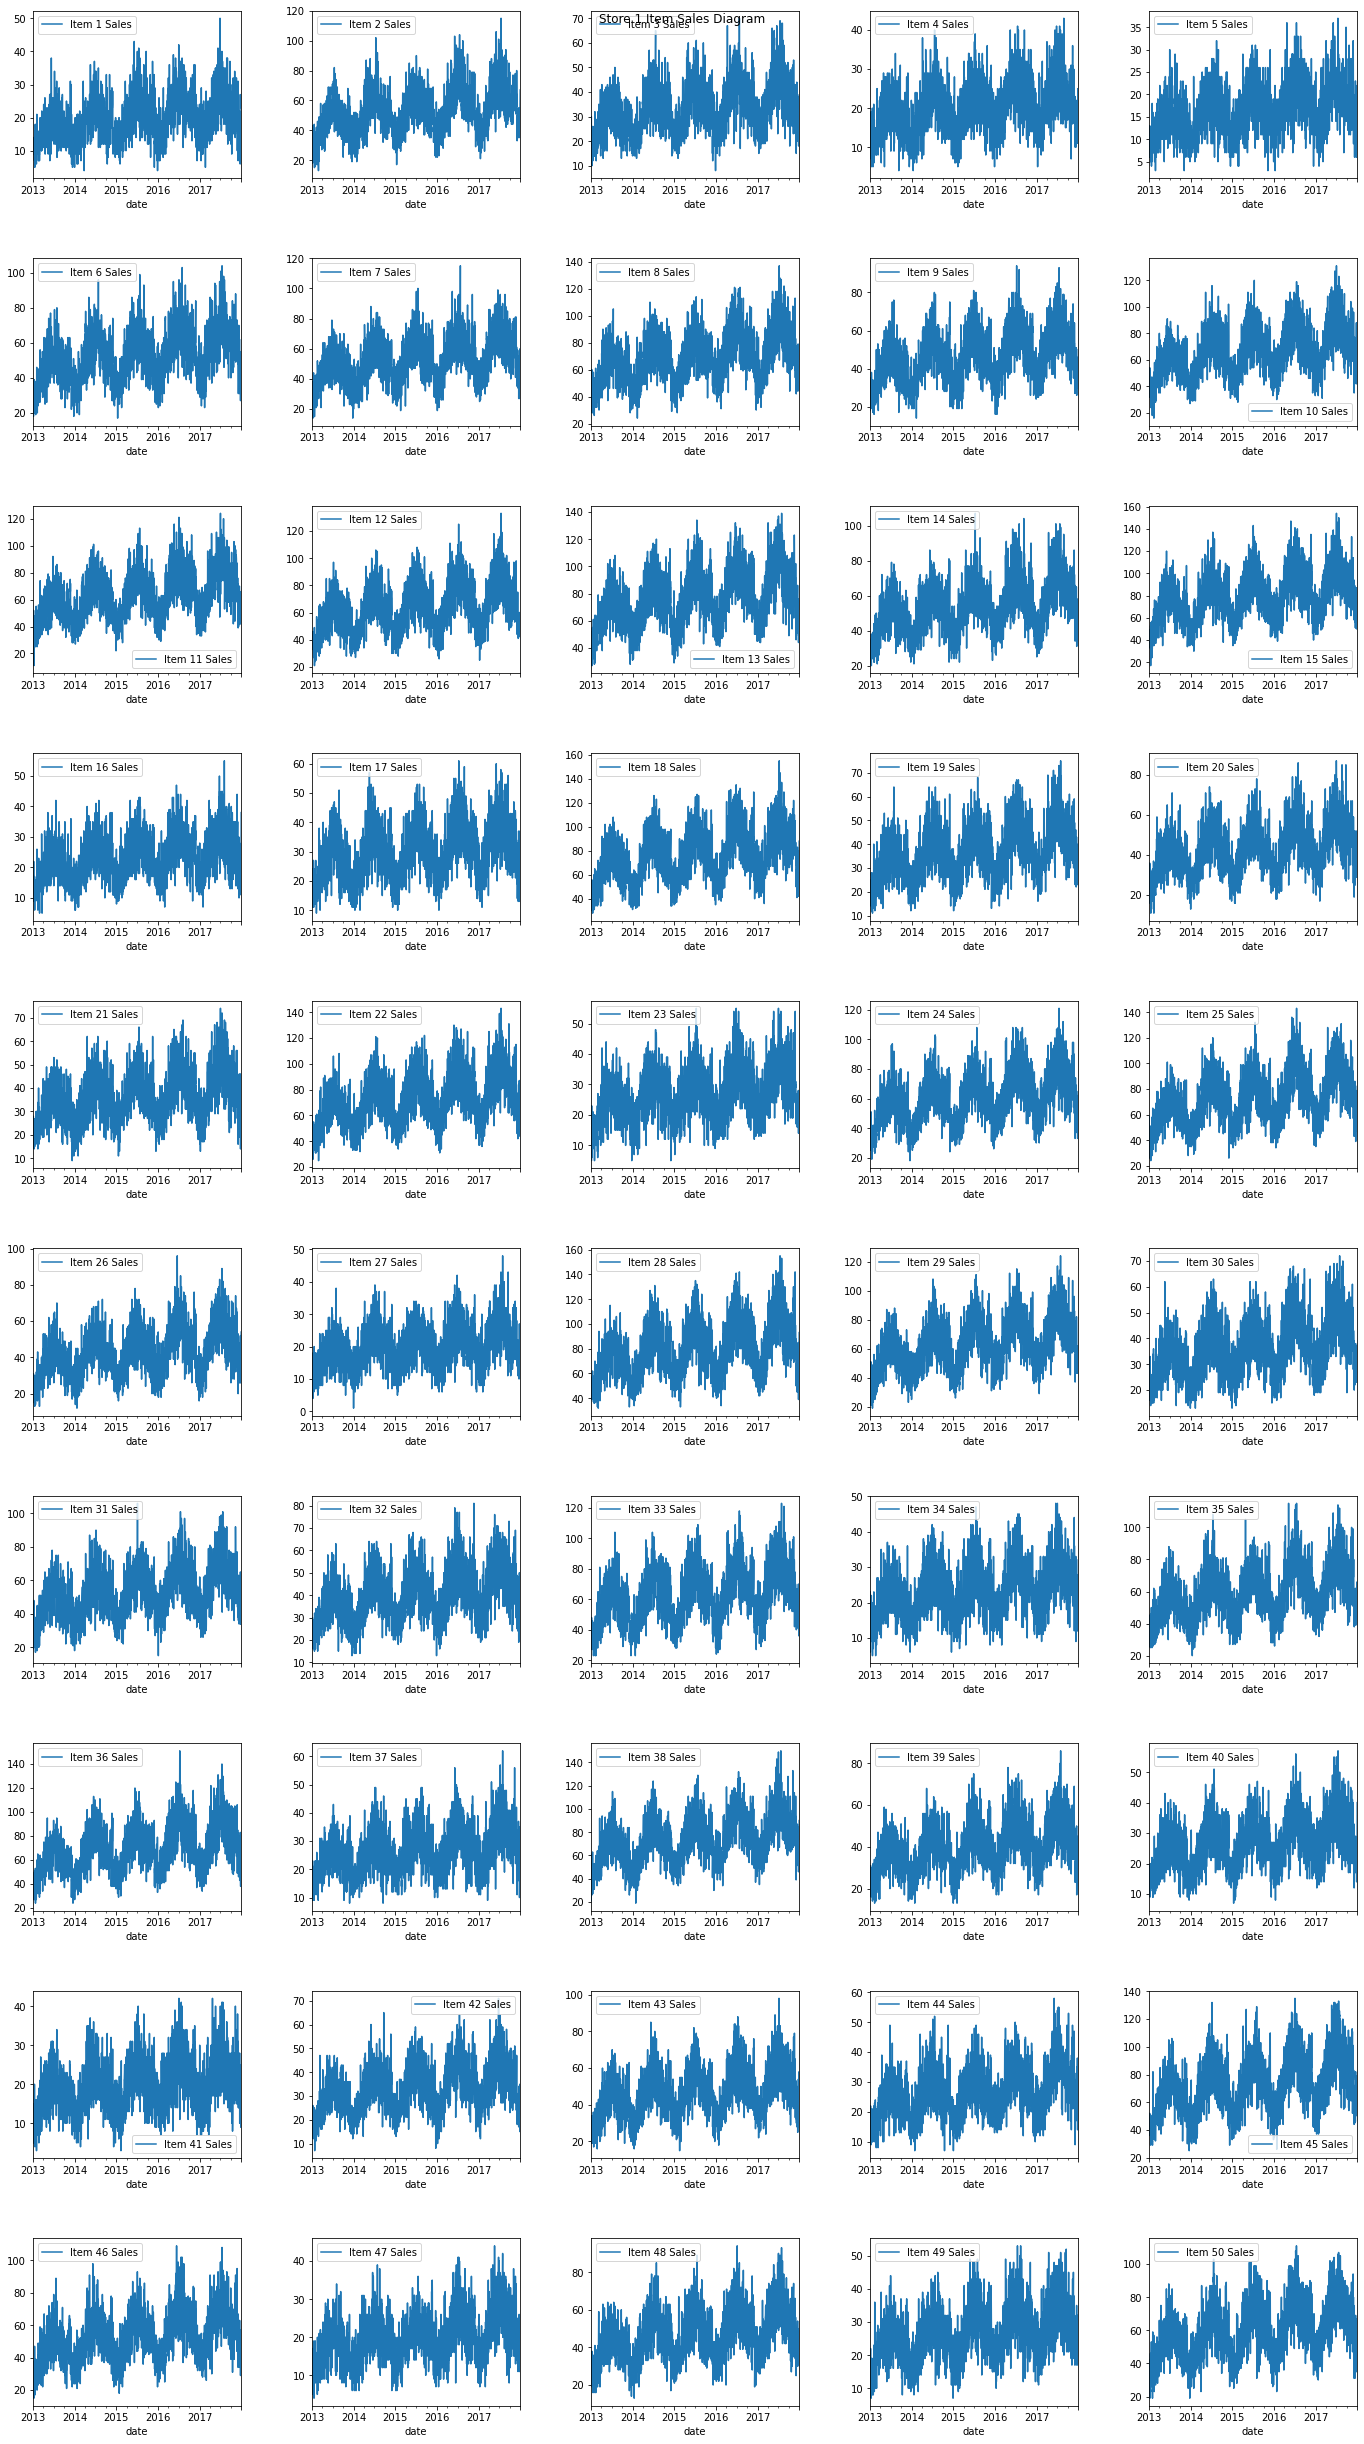

In [84]:
#distribution of sales of all items in store 1 
store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Sales Diagram");

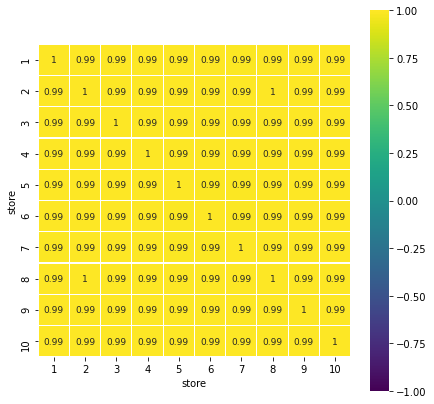

In [87]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

#### Hypothesis testing 

In [97]:

# T Test
def CompareTwoGroups(dataframe, group, target):
    
    import itertools
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # 1. Normality Test: Shapiro Test
    # 2. Homogeneity Test: Levene Test
    # 3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U
    
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], "GroupB_Count":[groupB.count()]
                            }, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", "p-value","GroupA_Median", "GroupB_Median","GroupA_Mean", "GroupB_Mean",
                                 "GroupA_Count", "GroupB_Count"]]])
        
    return AB
    
    
CompareTwoGroups(storesales, group = "store", target = "sales")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 2)",Non-Parametric,Different Groups,5.710857e-262,2339.5,3310.5,2363.418949,3351.658269,1826,1826
"(1, 3)",Non-Parametric,Different Groups,4.993303e-135,2339.5,2937.5,2363.418949,2976.530120,1826,1826
"(1, 4)",Non-Parametric,Different Groups,2.044904e-62,2339.5,2708.0,2363.418949,2745.147317,1826,1826
"(1, 5)",Non-Parametric,Different Groups,7.412486e-81,2339.5,1970.5,2363.418949,1988.508215,1826,1826
"(1, 6)",Non-Parametric,Different Groups,6.612336e-82,2339.5,1963.0,2363.418949,1986.675794,1826,1826
"(1, 7)",Non-Parametric,Different Groups,2.492221e-167,2339.5,1796.5,2363.418949,1818.186747,1826,1826
"(1, 8)",Non-Parametric,Different Groups,1.403421e-213,2339.5,3174.5,2363.418949,3207.102410,1826,1826
"(1, 9)",Non-Parametric,Different Groups,3.494276e-64,2339.5,2719.5,2363.418949,2752.451260,1826,1826
"(1, 10)",Non-Parametric,Different Groups,3.503530e-121,2339.5,2899.0,2363.418949,2935.464403,1826,1826
"(2, 3)",Non-Parametric,Different Groups,8.173908e-41,3310.5,2937.5,3351.658269,2976.530120,1826,1826


In [98]:
# items
itemsales = train.groupby(["date", "item"]).sales.sum().reset_index().set_index("date")
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 4)",Non-Parametric,Similar Groups,0.421191,218.0,218.0,219.815991,220.102410,1826,1826
"(1, 27)",Non-Parametric,Similar Groups,0.373126,218.0,218.0,219.815991,220.497262,1826,1826
"(1, 41)",Non-Parametric,Similar Groups,0.480811,218.0,218.0,219.815991,220.021358,1826,1826
"(1, 47)",Non-Parametric,Similar Groups,0.473073,218.0,217.0,219.815991,220.033406,1826,1826
"(2, 6)",Non-Parametric,Similar Groups,0.449726,578.0,578.5,585.741512,585.038883,1826,1826
...,...,...,...,...,...,...,...,...,...
"(40, 44)",Non-Parametric,Similar Groups,0.244793,289.0,291.0,292.493976,293.981928,1826,1826
"(40, 49)",Non-Parametric,Similar Groups,0.384739,289.0,289.0,292.493976,293.353231,1826,1826
"(41, 47)",Non-Parametric,Similar Groups,0.496844,218.0,217.0,220.021358,220.033406,1826,1826
"(43, 48)",Non-Parametric,Similar Groups,0.451168,508.5,506.0,512.943593,513.528478,1826,1826


### Feature Engineering 
- Time Related Features
- Moving Average Features
- Hypothesis Testing: Similarity Features
- Lagged Features
- Exponentially Weighted Mean Features

In [155]:
#adding time related features 
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df
df = create_date_features(df)

In [156]:
# Rolling Summary Stats Features
for i in [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]:
    df["sales_roll_mean_"+str(i)]=df.groupby(["store", "item"]).sales.rolling(i).mean().shift(1).values

In [157]:
# Store Based
storesales = train.groupby(["date", "store"]).sales.sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store", target="sales")
del storesales
# 2. Hypothesis Testing: Similarity
df["StoreSalesSimilarity"] = np.where(df.store.isin([3,10]), 1, 0)
df["StoreSalesSimilarity"] = np.where(df.store.isin([4,9]), 2, df["StoreSalesSimilarity"])
df["StoreSalesSimilarity"] = np.where(df.store.isin([5,6]), 3, df["StoreSalesSimilarity"])

In [158]:
# Item Based

itemsales = train.groupby(["date", "item"]).sales.sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
del itemsales

df["ItemSalesSimilarity"] = np.where(df.item.isin([1,4,27,41,47]), 1, 0)
df["ItemSalesSimilarity"] = np.where(df.item.isin([2,6,7,14,31,46]), 2, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([3,42]), 3, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([8,36]), 4, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([9,43,48]), 5, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([11,12,29,33]), 6, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([13,18]), 7, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([15,28]), 8, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([16,34]), 9, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([19,21,30]), 10, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([20,26]), 11, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([22,25,38,45]), 12, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([23,37,40,44,49]), 13, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([24,35,50]), 14, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([32,39]), 15, df["ItemSalesSimilarity"])


In [159]:
# 3. Lag/Shifted Features
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

df = lag_features(df, lags = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
                              182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
                              365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
                              730, 800, 900, 950, 990, 1000, 1050, 1090, 1095],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

In [166]:
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["sales"]].corr().sales.sort_values(ascending = False).index[1:index]
   
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
   
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(df, "sales_lag", 16)

In [167]:
# 4. Last i. Months
df["monthyear"] = df.date.dt.to_period('M')

In [177]:
# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]:
    last_months = df.groupby(["store", "item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'item', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how   = "left", on = ["store", "item", "monthyear"])
del last_months, i

drop_cor(df, "last_", 15)


In [178]:
# Store Based


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["store", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["store", "monthyear"])
del last_months, i


In [179]:
# Item Based
for i in [3, 6, 9, 12]:
    last_months = df.groupby(["item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['item', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["item", "monthyear"])
del last_months, i

In [180]:
# Similarity Based


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["StoreSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["ItemSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

df.drop("monthyear", axis = 1, inplace = True)



In [181]:
# 5. Last i. day of week
#####################################################
df.sort_values(["store", "item", "day_of_week", "date"], inplace = True)

df = lag_features(df, lags = np.arange(12,41, 1).tolist()+[91, 92, 95, 98, 99, 100, 105, 112, 119, 126, 133, 140, 200, 205, 210, 215, 220, 250],
                  groups = ["store", "item", "day_of_week"], target = 'sales', prefix = 'dayofweek_sales_lag_')

df[df.columns[df.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(df, "dayofweek_sales_lag_", 16)

df.sort_values(["store", "item", "date"], inplace = True)

In [182]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

df.shape


(958000, 204)

### Model Building and Training 
#### Train-Validation Split 

In [183]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

In [184]:
# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]

In [185]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((867000,), (867000, 200), (46000,), (46000, 200))

In [186]:
#We define our cost function using SMAPE
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

#### first model using default parameters 

In [187]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 13.155957997012594
VALID SMAPE: 12.738748750719312


#### feature importance 

In [188]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                              feature  split       gain
37                      sales_lag_364    256  50.580649
31                      sales_lag_350    108  12.156592
140            dayofweek_sales_lag_12    133  10.440039
56           last_12months_sales_mean    206   5.735309
197        sales_ewm_alpha_05_lag_365     49   3.399728
182         sales_ewm_alpha_07_lag_91     22   2.825599
6                         day_of_week    203   1.328763
55            last_12months_sales_sum     49   1.170474
141            dayofweek_sales_lag_13     14   0.978115
156        sales_ewm_alpha_095_lag_98     13   0.790030
199        sales_ewm_alpha_05_lag_728     28   0.700036
173         sales_ewm_alpha_08_lag_91     10   0.660893
148           dayofweek_sales_lag_105     34   0.652978
188        sales_ewm_alpha_07_lag_365     21   0.618589
155        sales_ewm_alpha_095_lag_91      4   0.501042
190        sales_ewm_alpha_07_lag_728     11   0.482588
2                               month    134   0

In [189]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((200, 3), (175, 3), (14, 3))

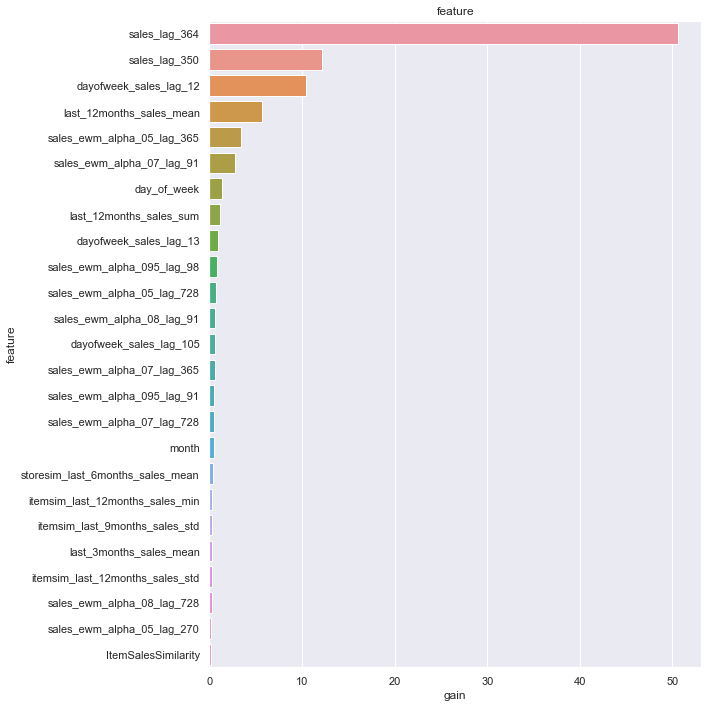

In [190]:
plot_lgb_importances(first_model, plot=True, num=30)